In [2]:
from openai import OpenAI
import instructor
# Apply the patch to the OpenAI client
# enables response_model keyword
client = instructor.from_openai(OpenAI())

In [ ]:
import utils.quality_evaluator

In [4]:
import importlib
import utils.qualitymetrics
import utils.quality_evaluator
importlib.reload(utils.qualitymetrics)
importlib.reload(utils.quality_evaluator)
from utils.qualitymetrics import *
from utils.quality_evaluator import * # type: ignore

In [5]:
# Data Handling and Processing
import pandas as pd
import numpy as np
import itertools

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/home/yang/.cache/kagglehub/datasets/thedrcat/daigt-v3-train-dataset/versions/2/train_v3_drcat_02.csv")
embedding_df = pd.read_pickle('embedding_all-MiniLM-L6-v2.pkl')
df = pd.concat([df, embedding_df], axis=1)

In [6]:
import json
import os
from datetime import datetime

# Function to evaluate essays and save results step by step
def evaluate_and_save(df, modelname, response_model, system_message_content, text_column, filename, max_wc = 512):
    evaluator = EssayEvaluator(system_message_content, modelname, response_model)
    results = []
    # Check if filename exists, if not, create a new filename
    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
        response_model_class_name = response_model.__name__
        filename = f"response_{modelname}_{response_model_class_name}_{timestamp}.json"

    counter = 0
    for index, row in df.iterrows():
        embedded_text = row[text_column]
        if max_wc is not None: 
            embedded_text = ' '.join(embedded_text.split(' ')[:max_wc])
        result = evaluator.evaluate_essay(embedded_text)
        results.append({
            'index': index,
            'text_substring': embedded_text,
            'evaluation': dict(result)
        })
        counter +=1
        # Save results to file after each iteration to avoid data loss
        if counter % 20 == 0:
            with open(filename, 'w') as f:
                json.dump(results, f, indent=4)
            
            print(f"Processed texts: {counter}")
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)
    print("Evaluation results saved successfully.")


select part of dataframe to sample from. 

read all essays fixed by ai

In [7]:

# Directory containing the text files
directory = './data/elect_rewrite_fix_human_typo/'

# Initialize an empty list to store the data
data = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        # Extract the index from the filename
        index = int(filename.split('.')[0])
        
        # Read the content of the file
        with open(os.path.join(directory, filename), 'r') as file:
            text = file.read()
        
        # Append the index and text to the data list
        data.append({'index': index, 'text': text})

# Create a dataframe from the data list
rewritedf = pd.DataFrame(data)
rewritedf.head(3)

,index,text
0,20241,What is the Electoral College? The Electoral C...
1,19006,"Dear Senator,\n\nI feel the need to eliminate ..."
2,19145,In the intense debate concerning the validity ...


In [8]:
topics_dict = {
'elect': 'Does the electoral college work?', 
'comm': 'Community service', 
'grades': 'Grades for extracurricular activities', 
'cowboy':'"A Cowboy Who Rode the Waves"', 
'phone': 'Cell phones at school',
}

In [10]:

human_list = ['persuade_corpus', 'train_essays']
# Top tier models for text generation
ai_top_list = [
    'radekgpt4', 'nima_gpt4', 'chat_gpt_moth',
    'darragh_claude_v7', 'llama_falcon_v3_falcon_180b',
    'llama_70b_v1', 'llama2_chat', 'falcon_180b_v1', 
    'mistral7binstruct_v2', 'mistralai/Mistral-7B-Instruct-v0.1', 'llama_70b_v1', 'Mistral7B_CME_v7']


In [11]:

topic = 'elect'
currdf = df[(df['prompt_name'] == topics_dict[topic])&df['source'].isin(human_list+ai_top_list)]
display(currdf['source'].value_counts())
aisampledf = currdf.groupby('source').apply(lambda x: x.sample(0 if len(x)<30 else 50 if len(x)>50 else len(x), random_state=42)).reset_index(drop=True)
aisampledf = aisampledf[aisampledf['model'] != 'human']
non_human_count = aisampledf[aisampledf['model'] != 'human'].shape[0]
humansampledf = currdf[currdf['source']=='persuade_corpus'].sample(n=int(non_human_count/2), random_state=42)
#sampledf = currdf[currdf['source']=='persuade_corpus'].sample(n=300, random_state=42)
sampledf = pd.concat([aisampledf, humansampledf], axis=0)
display(sampledf['source'].value_counts())


source
persuade_corpus                       2046
Mistral7B_CME_v7                       699
train_essays                           670
llama_falcon_v3_falcon_180b            494
mistralai/Mistral-7B-Instruct-v0.1     200
radekgpt4                              100
nima_gpt4                               84
darragh_claude_v7                       74
llama_70b_v1                            31
falcon_180b_v1                          24
chat_gpt_moth                            3
llama2_chat                              2
mistral7binstruct_v2                     1
Name: count, dtype: int64

/tmp/ipykernel_145508/855007502.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aisampledf = currdf.groupby('source').apply(lambda x: x.sample(0 if len(x)<30 else 50 if len(x)>50 else len(x), random_state=42)).reset_index(drop=True)


source
persuade_corpus                       165
Mistral7B_CME_v7                       50
darragh_claude_v7                      50
llama_falcon_v3_falcon_180b            50
mistralai/Mistral-7B-Instruct-v0.1     50
nima_gpt4                              50
radekgpt4                              50
llama_70b_v1                           31
Name: count, dtype: int64

In [12]:
humansampledf2 = currdf[(currdf['source']=='persuade_corpus') & (~currdf.index.isin(humansampledf.index))].sample(n=int(non_human_count/2)+1, random_state=42)

In [13]:
with open('./utils/prompt_ai.txt', 'r') as file:
    prompt = file.read()

formatted_prompt = prompt.format(metric_class_name=EssayQualityMetricsWithAI.__name__)
print(formatted_prompt)

Evaluate the following essay using the quality metrics defined in EssayQualityMetricsWithAI. This Pydantic model measures the quality of English essays based on a few metrics. 

For the number of grammatical and spelling errors, which are counted as integers. Please list all instances of grammatical and spelling mistakes exactly as they appear in the original text. Note: The input text is truncated to approximately 512 words, and abrupt endings do not affect the quality metrics. Provide the evaluation in JSON format.

All other essay quality metrics, except for grammatical errors and spelling mistakes, are rated on a scale of 0 to 5, with 5 being the best. Note: The input text is truncated to around 512 tokens, and abrupt endings do not contribute towards essay quality metrics.

For the task of evaluating the likelihood of AI generation, assess whether the following text is likely to be generated by AI using the chain of thought method. Start by breaking down linguistic patterns, coher

## start evaluation

In [14]:
testdf = rewritedf
#evaluate_and_save(testdf, "gpt-4o-mini",  QuantitativeTextQualityMetrics, formatted_prompt, 'text', f'{topic}_test_10', 512)
evaluate_and_save(testdf, "gpt-4o-mini",  EssayQualityMetricsWithAI, formatted_prompt, 'text', f'{topic}_human_rewrite.json', 512)

Processed texts: 20
Processed texts: 40
Processed texts: 60
Processed texts: 80
Processed texts: 100
Processed texts: 120
Processed texts: 140
Processed texts: 160
Processed texts: 180
Processed texts: 200
Processed texts: 220
Processed texts: 240
Processed texts: 260
Processed texts: 280
Processed texts: 300
Processed texts: 320
Evaluation results saved successfully.


In [97]:
filedf = pd.read_json(f'{topic}_human_rewrite.json')
rewriteevaldf = pd.json_normalize(filedf['evaluation'])
rewriteevaldf = pd.concat([rewritedf, rewriteevaldf], axis=1)
rewriteevaldf.to_pickle(f'./data/{topic}_human_rewrite_evaldf.pkl')
rewriteevaldf.sample(3)

,index,text,embedding,text_embedded,text_embedding_tc,number_of_grammatical_errors,number_of_spelling_mistakes,grammatical_errors,spelling_mistakes,sentence_complexity,...,sentence_clarity,engagement_score,sentiment_alignment,style_consistency,relevance_score,evidence_support,originality_and_creativity,likelihood_of_ai,reasoning_of_likelihood_of_ai,substrings_of_high_likelihood_of_ai
14,19717,"Dear state senator,\n\nMy letter is in regards...","[-0.001837517018429935, -0.039352741092443466,...","dear state senator, my letter is in regards to...",510,3,0,"[either way, there are those types of people w...",[],3,...,3,4,4,4,5,3,4,2,The essay shows coherent arguments and a clear...,[]
115,20493,Americans throughout the country believe that ...,"[0.005950792692601681, -0.052766405045986176, ...",americans throughout the country believe that ...,510,5,1,[the people want is almost always the risky op...,[glories],3,...,4,4,4,4,5,3,3,3,The text exhibits some potential markers of AI...,[the people want is almost always the risky op...
321,19790,I think that we should change from the Elector...,"[0.012596279382705688, -0.0509168840944767, 0....",i think that we should change from the elector...,510,0,1,[],[fiasco],3,...,4,4,4,4,5,4,3,3,The text contains some patterns typically asso...,"[the biggest election crisis in a century, It ..."


# plot and evaluate the results

In [98]:
rewriteevaldf['Author'] = 'AI-Fixed'
rewriteevaldf['model'] = 'gpt-4o-mini-Fixed'
rewriteevaldf['label'] = 2

In [99]:

evaldf = pd.read_pickle(f'{topic}_evaldf.pkl')

In [100]:
evaldf = pd.concat([evaldf, rewriteevaldf], axis=0)

In [ ]:
#evaldf.to_pickle(f'./data/{topic}_evaldf_with_aifixed.pkl')

In [115]:
evaldf = pd.read_pickle(f'./data/{topic}_evaldf_with_aifixed.pkl')

In [116]:
evaldf['Author'] = evaldf['Author'].replace({'AI-Fixed': 'Human+GPT', 'Human': 'Human', 'AI': 'LLM'})

In [117]:
evaldf.groupby('Author')[['number_of_spelling_mistakes', 'number_of_grammatical_errors']].mean().round(3)

,number_of_spelling_mistakes,number_of_grammatical_errors
Author,,
Human,5.225,7.496
Human+GPT,0.239,3.592
LLM,0.257,1.066


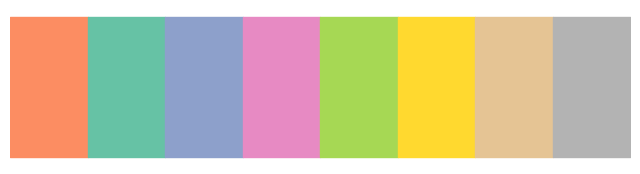

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the Set1 colormap
set1_colors = sns.color_palette("Set2")

# Switch the first two colors
custom_palette = set1_colors.copy()
custom_palette[0], custom_palette[1] = custom_palette[1], custom_palette[0]

# Plot the custom palette
plt.figure(figsize=(8, 2))
for i, color in enumerate(custom_palette):
    plt.fill_between([i, i+1], 0, 1, color=color)
plt.xlim(0, len(custom_palette))
plt.axis('off')
plt.show()

In [63]:
evaldf['Author'].value_counts()

Author
Human       351
AI          331
AI-Fixed    331
Name: count, dtype: int64

/tmp/ipykernel_145508/733127268.py:4: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.histplot(data=evaldf, x='number_of_spelling_mistakes', hue='Author', hue_order = ['AI', 'Human', 'AI-Fixed'], \
/tmp/ipykernel_145508/733127268.py:14: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.histplot(data=evaldf, x='number_of_grammatical_errors', hue='Author', hue_order = ['AI', 'Human', 'AI-Fixed'], \


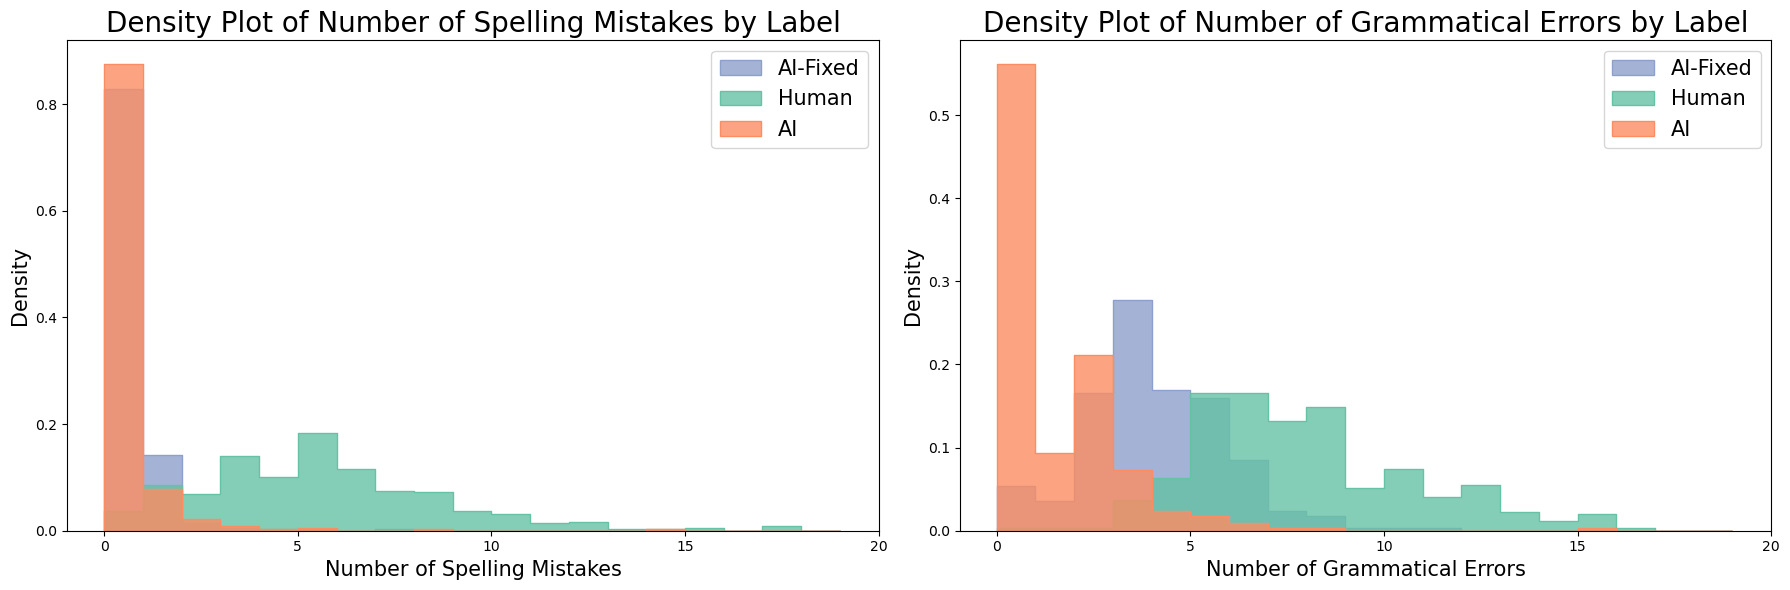

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for number_of_spelling_mistakes
sns.histplot(data=evaldf, x='number_of_spelling_mistakes', hue='Author', hue_order = ['AI', 'Human', 'AI-Fixed'], \
             palette=custom_palette,
             element='step', stat='density', common_norm=False, alpha=0.8, bins=range(0, 20), ax=axes[0])
axes[0].set_title('Density Plot of Number of Spelling Mistakes by Label', fontsize=20)
axes[0].set_xlabel('Number of Spelling Mistakes', fontsize=15)
axes[0].set_ylabel('Density', fontsize=15)
axes[0].legend(title='', labels=['AI-Fixed', 'Human', 'AI'], fontsize=15)
axes[0].set_xticks(range(0, 21, 5))  # Set x-ticks at intervals of 5

# Plot for number_of_grammatical_errors
sns.histplot(data=evaldf, x='number_of_grammatical_errors', hue='Author', hue_order = ['AI', 'Human', 'AI-Fixed'], \
             palette=custom_palette, element='step', stat='density', common_norm=False, alpha=0.8, bins=range(0, 20), ax=axes[1])
axes[1].set_title('Density Plot of Number of Grammatical Errors by Label', fontsize=20)
axes[1].set_xlabel('Number of Grammatical Errors', fontsize=15)
axes[1].set_ylabel('Density', fontsize=15)
axes[1].legend(title='', labels=['AI-Fixed', 'Human', 'AI'], fontsize=15)
axes[1].set_xticks(range(0, 21, 5))  # Set x-ticks at intervals of 5

plt.tight_layout()
plt.show()


In [31]:
ordinal_evaluation_keys = [ 'sentence_complexity',
 'lexical_diversity',
 'vocabulary_sophistication',
 'coherence_score',
 'cohesion_score',
 'argument_structure',
 'readability_index',
 'sentence_clarity',
 'engagement_score',
 'sentiment_alignment',
 'style_consistency',
 'relevance_score',
 'evidence_support',
 'originality_and_creativity', 'likelihood_of_ai']

In [32]:
evaldf['wc_of_perceived_ai_text'] = evaldf['substrings_of_high_likelihood_of_ai'].apply(lambda l: np.sum([len(x.split()) for x in l]))
evaldf['number_of_perceived_ai_text'] = evaldf['substrings_of_high_likelihood_of_ai'].apply(lambda l: len(l))

/tmp/ipykernel_145508/714056594.py:4: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.histplot(data=evaldf, x='wc_of_perceived_ai_text', hue='Author', hue_order = ['AI', 'Human', 'AI-Fixed'], \
/tmp/ipykernel_145508/714056594.py:14: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.histplot(data=evaldf, x='number_of_perceived_ai_text', hue='Author', hue_order = ['AI', 'Human', 'AI-Fixed'], \


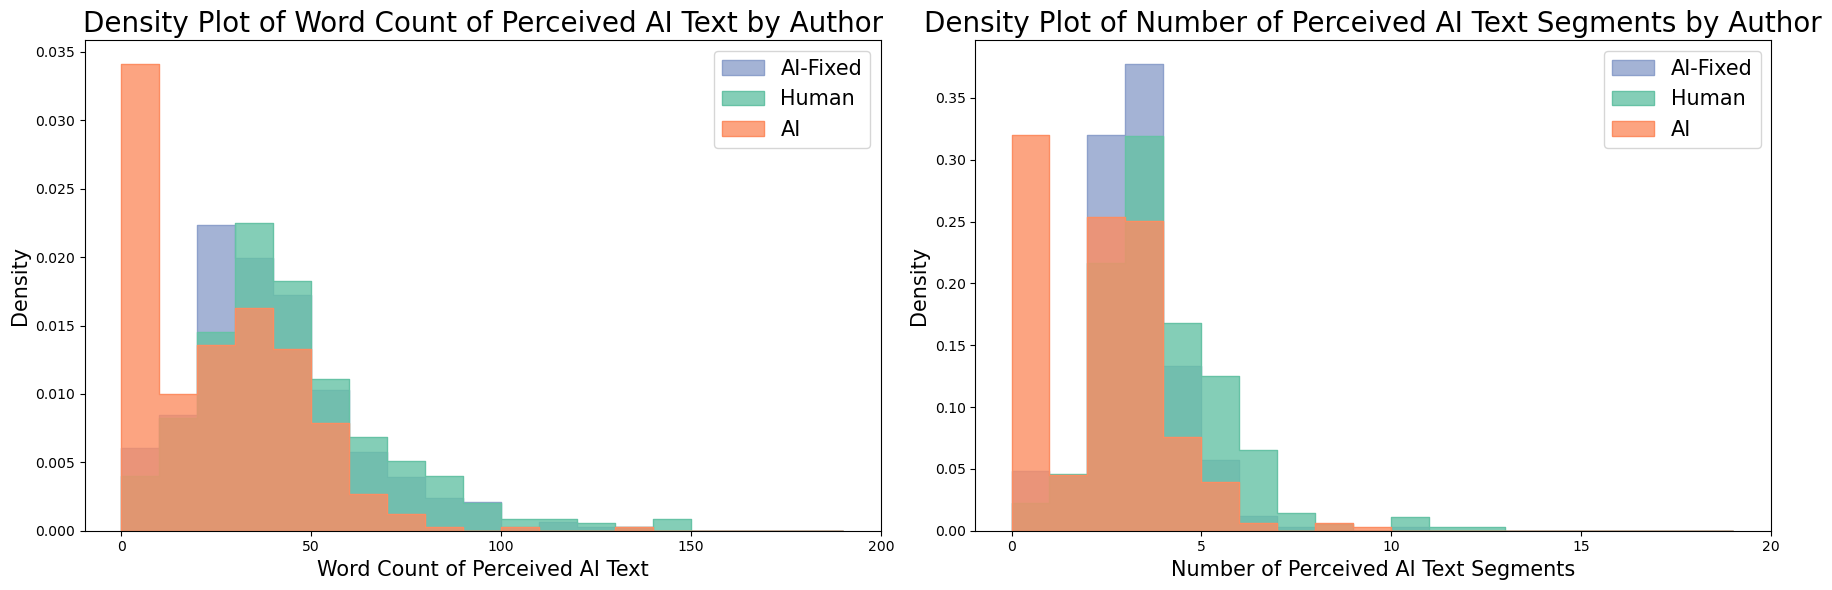

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for number_of_spelling_mistakes
sns.histplot(data=evaldf, x='wc_of_perceived_ai_text', hue='Author', hue_order = ['AI', 'Human', 'AI-Fixed'], \
             palette=custom_palette,
             element='step', stat='density', common_norm=False, alpha=0.8, bins=range(0, 200, 10), ax=axes[0])
axes[0].set_title('Density Plot of Word Count of Perceived AI Text by Author', fontsize=20)
axes[0].set_xlabel('Word Count of Perceived AI Text', fontsize=15)
axes[0].set_ylabel('Density', fontsize=15)
axes[0].legend(title='', labels=['AI-Fixed', 'Human', 'AI'], fontsize=15)
axes[0].set_xticks(range(0, 201, 50))  # Set x-ticks at intervals of 50

# Plot for number_of_perceived_ai_text
sns.histplot(data=evaldf, x='number_of_perceived_ai_text', hue='Author', hue_order = ['AI', 'Human', 'AI-Fixed'], \
             palette=custom_palette, element='step', stat='density', common_norm=False, alpha=0.8, bins=range(0, 20), ax=axes[1])
axes[1].set_title('Density Plot of Number of Perceived AI Text Segments by Author', fontsize=20)
axes[1].set_xlabel('Number of Perceived AI Text Segments', fontsize=15)
axes[1].set_ylabel('Density', fontsize=15)
axes[1].legend(title='', labels=['AI-Fixed', 'Human', 'AI'], fontsize=15)
axes[1].set_xticks(range(0, 21, 5))  # Set x-ticks at intervals of 5

plt.tight_layout()
plt.show()



In [35]:
evaldf['wc_of_ai_text'] = evaldf['text_substring'].apply(lambda x: len(x.split()))

AttributeError: 'float' object has no attribute 'split'

In [118]:
evaldf.groupby('Author')[ordinal_evaluation_keys ].mean().round(3).T

Author,Human,Human+GPT,LLM
sentence_complexity,2.476,2.873,3.776
lexical_diversity,2.895,3.305,3.870
vocabulary_sophistication,2.160,2.565,3.353
coherence_score,3.020,3.553,4.299
cohesion_score,2.809,3.414,4.199
argument_structure,3.054,3.489,4.248
readability_index,3.219,3.647,3.982
sentence_clarity,2.917,3.411,4.184
engagement_score,2.858,3.230,3.508
sentiment_alignment,3.439,3.716,4.211


In [37]:
import warnings

warnings.filterwarnings('ignore')

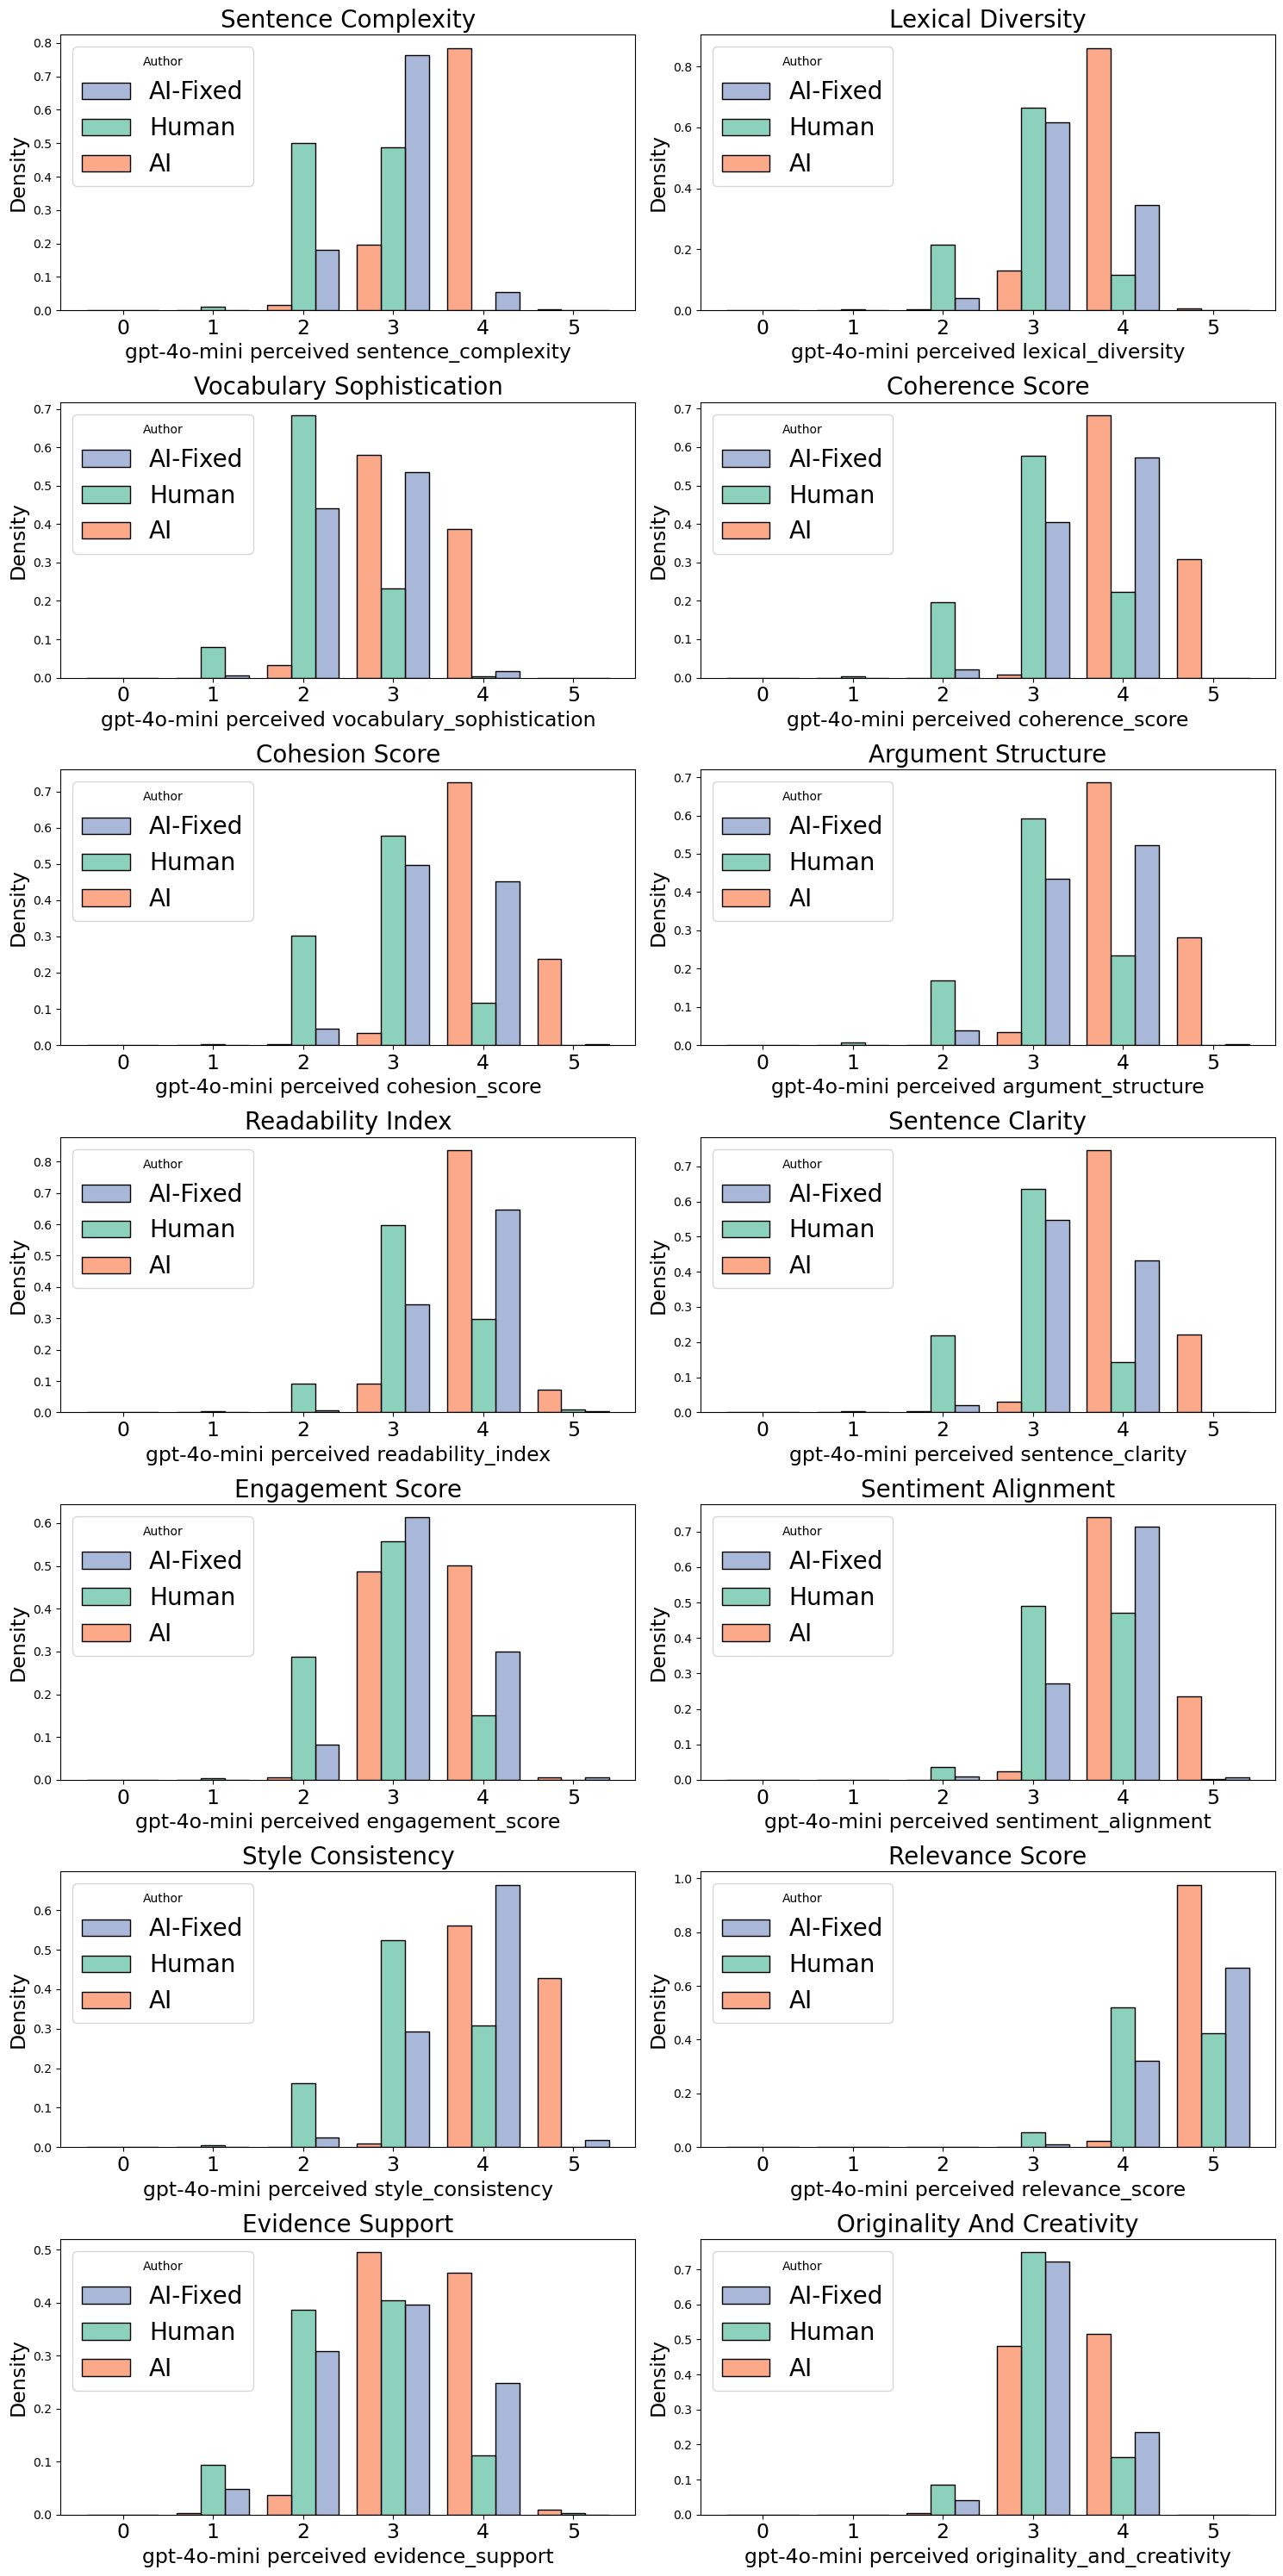

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 30))
axes = axes.flatten()

# Plot each ordinal evaluation key
for i, key in enumerate(ordinal_evaluation_keys[:-1]):
    sns.histplot(data=evaldf, x=key, hue='Author', hue_order = ['AI', 'Human', 'AI-Fixed'],  multiple='dodge', shrink=0.8, ax=axes[i], palette=custom_palette,  bins=range(7), stat='density', common_norm=False,)
    title = key.replace('_', ' ').title()
    axes[i].set_title(f'{title}', fontsize=20)
    axes[i].set_xlabel(f'gpt-4o-mini perceived {key}', fontsize=17)
    axes[i].set_ylabel('Density', fontsize=17)
    axes[i].legend(title='Author', labels=['AI-Fixed', 'Human', 'AI'], fontsize=20)
    axes[i].set_xticks([x + 0.5 for x in range(6)])  # Shift x-ticks by 0.5
    axes[i].set_xticklabels([0, 1, 2, 3, 4, 5], fontsize=17)  # Set x-tick labels

# Adjust layout
plt.tight_layout()
plt.show()

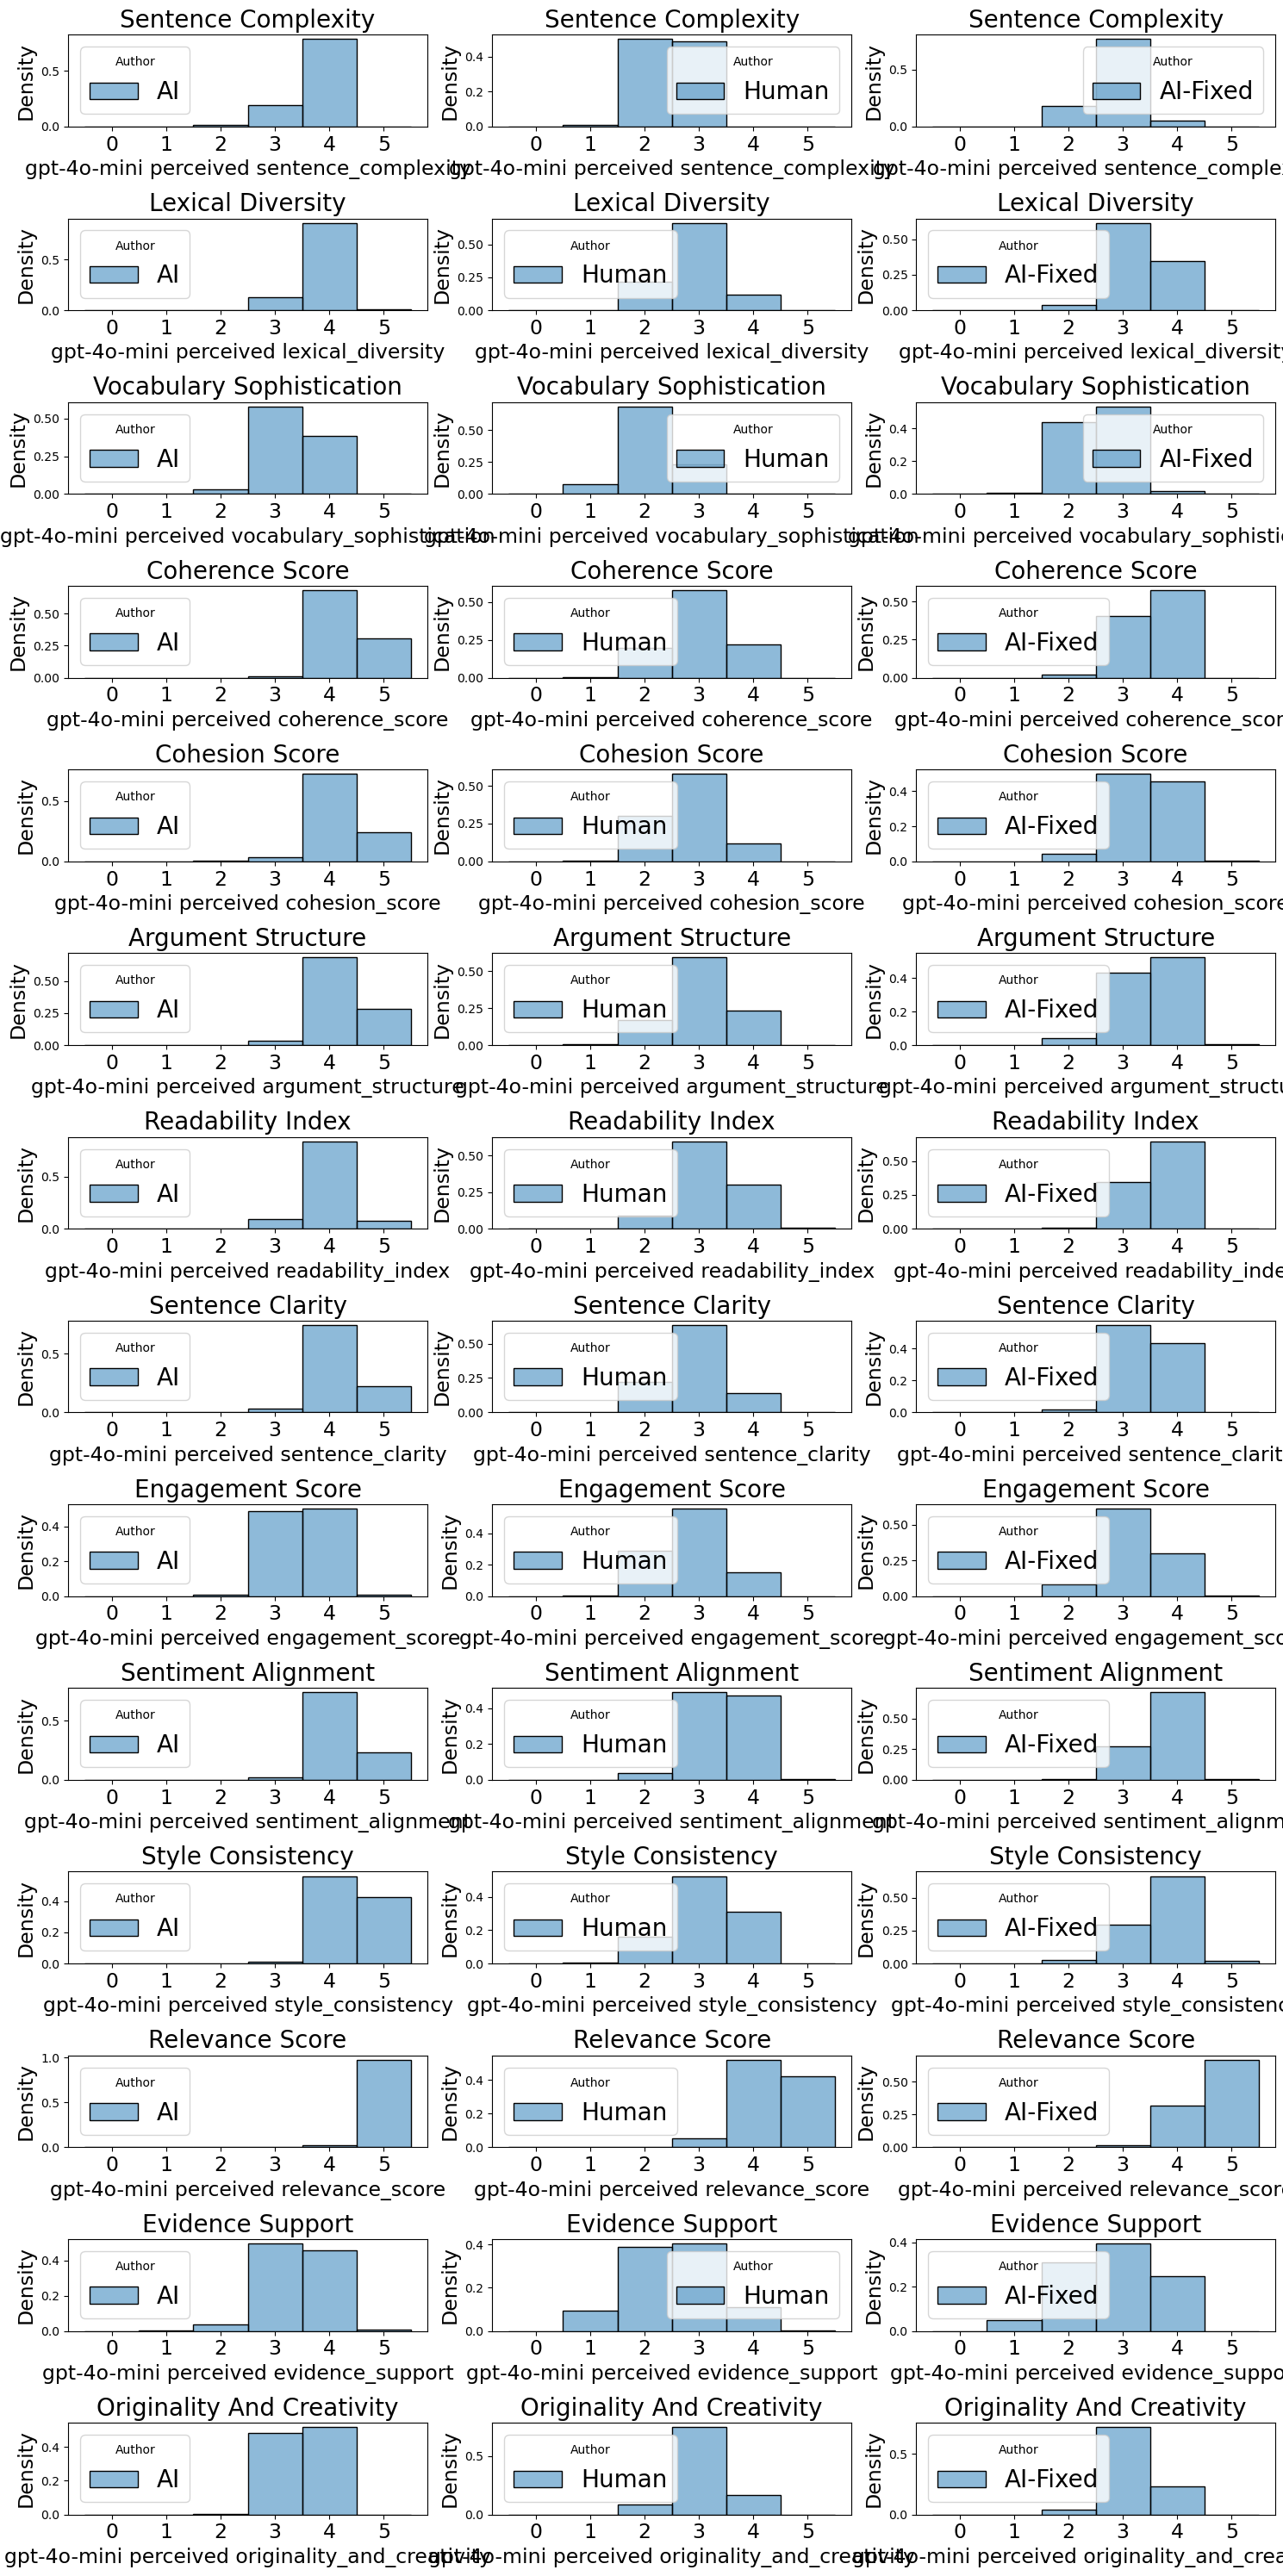

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=14, ncols=3, figsize=(15, 45))
axes = axes.flatten()
humancolor = custom_palette[0]
aicolor = custom_palette[1]
aifixcolor = custom_palette[2]

# Plot each ordinal evaluation key
for i, key in enumerate(ordinal_evaluation_keys[:-1]):
    for j, author in enumerate(['AI', 'Human', 'AI-Fixed']):
        subdf = evaldf[evaldf['Author'] == author]
        ax = axes[i*3 + j]
        color = custom_palette[j]
        sns.histplot(data=subdf, x=key, hue='Author', color =color, ax= ax,  bins=range(7), stat='density')
        title = key.replace('_', ' ').title()
        ax.set_title(f'{title}', fontsize=20)
        ax.set_xlabel(f'gpt-4o-mini perceived {key}', fontsize=17)
        ax.set_ylabel('Density', fontsize=17)
        ax.legend(title='Author', labels=[author], fontsize=20)
        ax.set_xticks([x + 0.5 for x in range(6)])  # Shift x-ticks by 0.5
        ax.set_xticklabels([0, 1, 2, 3, 4, 5], fontsize=17)  # Set x-tick labels

# Adjust layout
plt.tight_layout()
plt.show()

/tmp/ipykernel_2527/1277954911.py:8: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.histplot(data=evaldf, x=key, hue='Author', hue_order = ['AI', 'Human'],  \


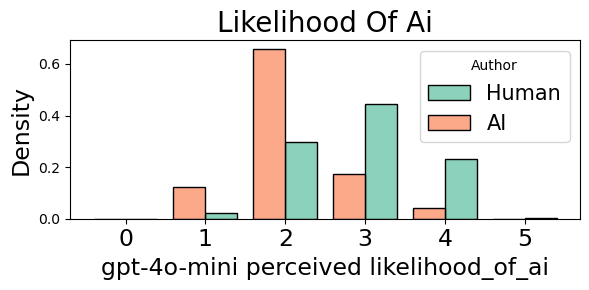

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 3))

# plot ai metric
sns.histplot(data=evaldf, x=key, hue='Author', hue_order = ['AI', 'Human'],  \
             multiple='dodge', shrink=0.8, ax=ax, palette=custom_palette,  \
                bins=range(7), stat='density', common_norm=False)
title = key.replace('_', ' ').title()
ax.set_title(f'{title}', fontsize=20)
ax.set_xlabel(f'gpt-4o-mini perceived {key}', fontsize=17)
ax.set_ylabel('Density', fontsize=17)
ax.legend(title='Author', labels=['Human', 'AI'], fontsize=15)
ax.set_xticks([x + 0.5 for x in range(6)])  # Shift x-ticks by 0.5
ax.set_xticklabels([0, 1, 2, 3, 4, 5], fontsize=17)  # Set x-tick labels

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'custom_palette' is not defined

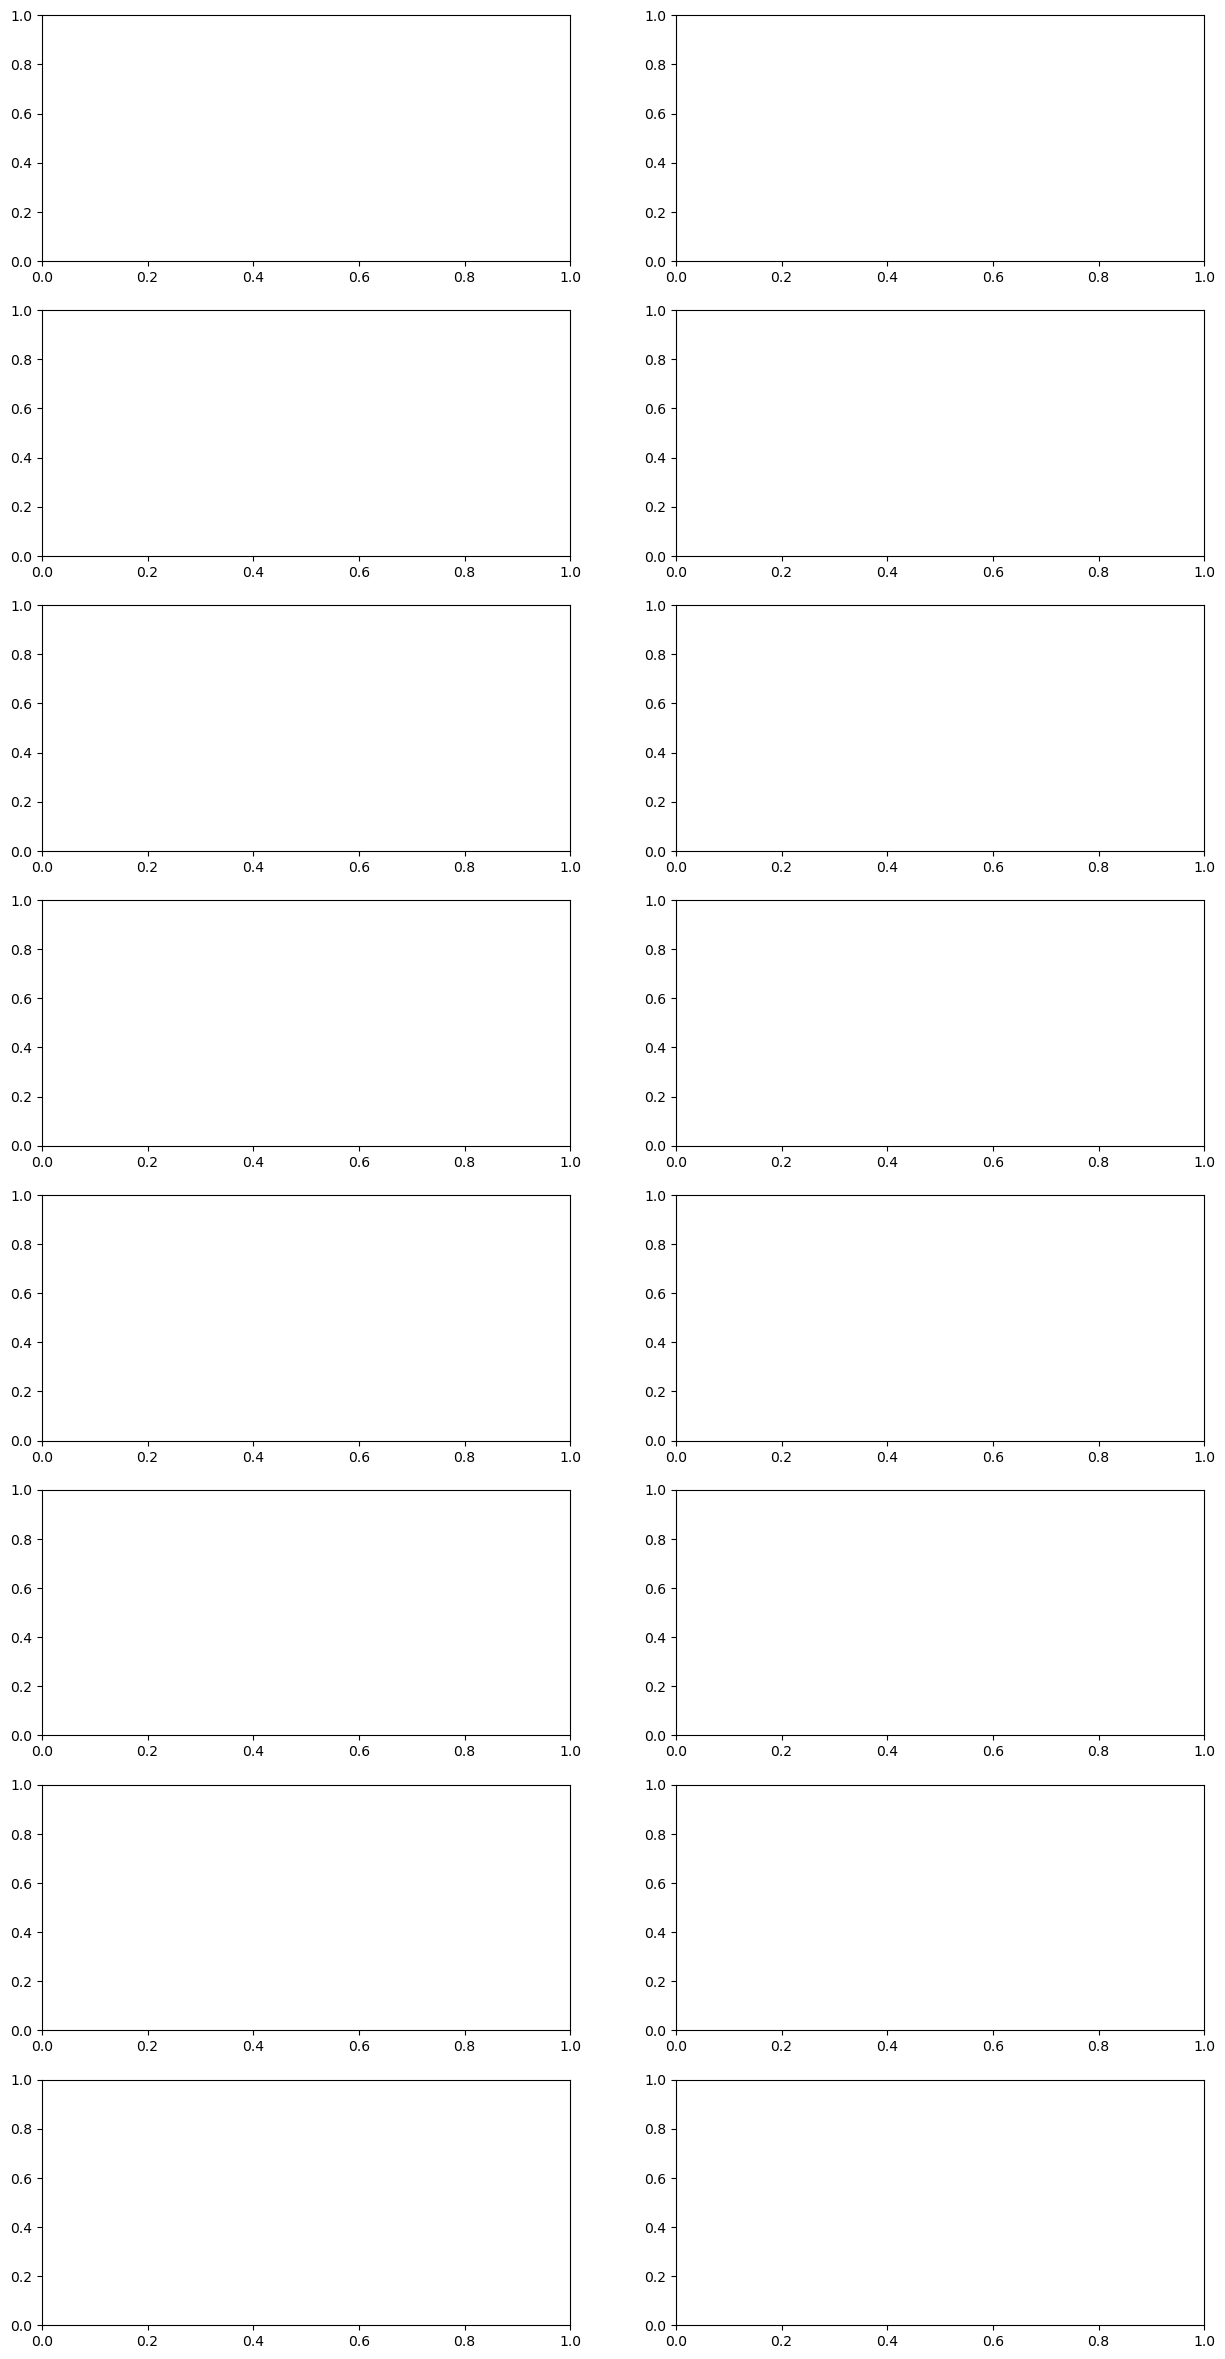

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 30))
axes = axes.flatten()

# Plot each ordinal evaluation key
for i, key in enumerate(ordinal_evaluation_keys):
    sns.histplot(data=evaldf, x=key, hue='Author', hue_order = ['AI', 'Human'],  multiple='dodge', shrink=0.8, ax=axes[i], palette=custom_palette,  bins=range(7), stat='density', common_norm=False)
    title = key.replace('_', ' ').title()
    axes[i].set_title(f'Distribution of {title} by Label', fontsize=20)
    axes[i].set_xlabel(key, fontsize=20)
    axes[i].set_ylabel('Density', fontsize=15)
    axes[i].legend(title='Author', labels=['Human', 'AI'])
    axes[i].set_xticks([x + 0.5 for x in range(7)])  # Shift x-ticks by 0.5

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
hue_order = [
 'persuade_corpus',
 'darragh_claude_v7',
 'llama_70b_v1',
 'llama_falcon_v3_falcon_180b',
 'Mistral7B_CME_v7',
 'mistralai/Mistral-7B-Instruct-v0.1',
 'nima_gpt4',
 'radekgpt4']

In [196]:
evaldf.to_pickle(f'{topic}_evaldf.pkl')
evaldf.to_csv(f'{topic}_evaldf.csv', index=False)

# Statistical significance: yes, those are some statistically significant identifiers. 

In [194]:
evaluation_keys = ['number_of_spelling_mistakes', 'number_of_grammatical_errors'] + ordinal_evaluation_keys

In [195]:
from scipy.stats import ttest_ind
print(evaldf.shape)

# Initialize a dictionary to store the results
comparison_results = {}

# Loop through each evaluation key
for key in evaluation_keys:
    # Separate the data based on the binary labela
    group_0 = evaldf[evaldf['Author'] == 'Human'][key]
    group_1 = evaldf[evaldf['Author'] == 'AI'][key]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)
    
    # Store the results
    comparison_results[key] = {'t_stat': t_stat, 'p_value': p_value}

# Display the results
for key, result in comparison_results.items():
    print(f"{key}: t_stat = {result['t_stat']:.4f}, p_value = {result['p_value']:.4f}")

(682, 33)
number_of_spelling_mistakes: t_stat = 25.6518, p_value = 0.0000
number_of_grammatical_errors: t_stat = 35.1445, p_value = 0.0000
sentence_complexity: t_stat = -34.5937, p_value = 0.0000
lexical_diversity: t_stat = -26.5435, p_value = 0.0000
vocabulary_sophistication: t_stat = -28.5472, p_value = 0.0000
coherence_score: t_stat = -29.2062, p_value = 0.0000
cohesion_score: t_stat = -32.1920, p_value = 0.0000
argument_structure: t_stat = -26.8879, p_value = 0.0000
readability_index: t_stat = -19.0548, p_value = 0.0000
sentence_clarity: t_stat = -30.3683, p_value = 0.0000
engagement_score: t_stat = -14.3255, p_value = 0.0000
sentiment_alignment: t_stat = -19.4200, p_value = 0.0000
style_consistency: t_stat = -27.7349, p_value = 0.0000
relevance_score: t_stat = -18.7111, p_value = 0.0000
evidence_support: t_stat = -16.2525, p_value = 0.0000
originality_and_creativity: t_stat = -11.3017, p_value = 0.0000
likelihood_of_ai: t_stat = 13.4949, p_value = 0.0000


## even for difference between AI and AI-fixed human text? 

In [53]:
evaluation_keys = ['number_of_spelling_mistakes', 'number_of_grammatical_errors'] + ordinal_evaluation_keys

In [54]:
from scipy.stats import ttest_ind
print(evaldf.shape)

# Initialize a dictionary to store the results
comparison_results = {}

# Loop through each evaluation key
for key in evaluation_keys:
    # Separate the data based on the binary labela
    group_0 = evaldf[evaldf['Author'] == 'AI'][key]
    group_1 = evaldf[evaldf['Author'] == 'AI-Fixed'][key]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)
    
    # Store the results
    comparison_results[key] = {'t_stat': t_stat, 'p_value': p_value}

# Display the results
for key, result in comparison_results.items():
    print(f"{key}: t_stat = {result['t_stat']:.4f}, p_value = {result['p_value']:.4f}")

(1013, 34)
number_of_spelling_mistakes: t_stat = 0.2575, p_value = 0.7969
number_of_grammatical_errors: t_stat = -18.8046, p_value = 0.0000
sentence_complexity: t_stat = 25.0424, p_value = 0.0000
lexical_diversity: t_stat = 15.8034, p_value = 0.0000
vocabulary_sophistication: t_stat = 18.6625, p_value = 0.0000
coherence_score: t_stat = 18.8482, p_value = 0.0000
cohesion_score: t_stat = 18.6803, p_value = 0.0000
argument_structure: t_stat = 17.9750, p_value = 0.0000
readability_index: t_stat = 9.5201, p_value = 0.0000
sentence_clarity: t_stat = 19.6116, p_value = 0.0000
engagement_score: t_stat = 6.3804, p_value = 0.0000
sentiment_alignment: t_stat = 13.4376, p_value = 0.0000
style_consistency: t_stat = 17.9602, p_value = 0.0000
relevance_score: t_stat = 11.1229, p_value = 0.0000
evidence_support: t_stat = 10.3042, p_value = 0.0000
originality_and_creativity: t_stat = 8.2568, p_value = 0.0000
likelihood_of_ai: t_stat = -10.1405, p_value = 0.0000


## use pca to find out how many actual dimensions there are out of all oridnal columns

In [45]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt




In [64]:
datadf = evaldf[evaldf['label'].isin([1, 2])]
datadf['Author'].value_counts()

Author
AI          331
AI-Fixed    331
Name: count, dtype: int64

In [68]:
X = np.array(datadf[ordinal_evaluation_keys])
X.shape

(662, 15)

Cumulative Explained Variance: [0.62632284 0.69578263 0.74519706 0.78358193 0.81905097 0.84584931
 0.86998327 0.89125016 0.91076493 0.92872169 0.94594657 0.96215991
 0.9772559  0.99139123 1.        ]


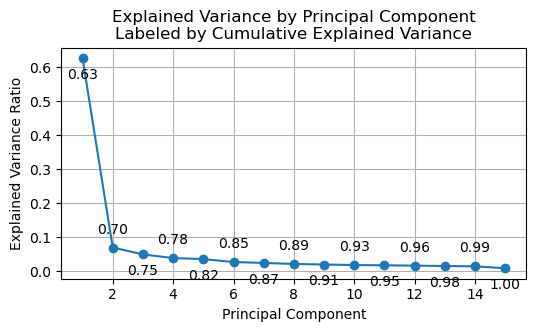

Effective number of dimensions: 12


In [66]:

# Apply PCA without specifying n_components to get all components
pca = PCA()
pca.fit(X)

# Explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance to visualize the intrinsic dimensionality
plt.figure(figsize=(6, 3))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component\nLabeled by Cumulative Explained Variance')
plt.grid(True)

# Cumulative explained variance to determine effective dimensions
cumulative_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Annotate cumulative variance below and above each point in repetition
for i, cv in enumerate(cumulative_variance):
    if i % 2 == 0:
        plt.annotate(f'{cv:.2f}', (i + 1, explained_variance[i]), textcoords="offset points", xytext=(0, -15), ha='center')
    else:
        plt.annotate(f'{cv:.2f}', (i + 1, explained_variance[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

# Determine number of components explaining ~95% of the variance
num_effective_dimensions = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Effective number of dimensions: {num_effective_dimensions}')


In [71]:
y = np.array(datadf['label'])

In [72]:
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model (you can use any classifier; LogisticRegression is used here)
model = LogisticRegression()

# Set up RFE for backward selection, specifying the number of features to select
n_features_to_select = 5  # Choose based on the effective dimensions or desired number
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)

# Fit RFE
rfe.fit(X_train, y_train)

# Selected features and ranking
selected_features = rfe.support_
feature_ranking = rfe.ranking_

# Transform train and test data to keep only the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Fit the model on the selected features and make predictions
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with selected features: {accuracy:.2f}')

# Output selected features
print("Selected features (True = kept, False = removed):", selected_features)
print("Feature ranking (1 = selected, higher numbers = removed first):", feature_ranking)



Accuracy with selected features: 0.87
Selected features (True = kept, False = removed): [ True False False  True False False False  True False False  True  True
 False False False]
Feature ranking (1 = selected, higher numbers = removed first): [ 1  8  2  1  7 10  5  1  4  3  1  1  9  6 11]


In [73]:
print(dict(sorted(zip(ordinal_evaluation_keys, feature_ranking), key=lambda x: x[1])))

{'sentence_complexity': 1, 'coherence_score': 1, 'sentence_clarity': 1, 'style_consistency': 1, 'relevance_score': 1, 'vocabulary_sophistication': 2, 'sentiment_alignment': 3, 'engagement_score': 4, 'readability_index': 5, 'originality_and_creativity': 6, 'cohesion_score': 7, 'lexical_diversity': 8, 'evidence_support': 9, 'argument_structure': 10, 'likelihood_of_ai': 11}


In [74]:
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

# Initialize the model (you can use any classifier; LogisticRegression is used here)
model = LogisticRegression()

# List to store cross-validated accuracy scores at each step
accuracy_scores = []
farr = []
# Perform backward selection iteratively
for n_features_to_select in range(X_train.shape[1], 0, -1):
    # Initialize RFE with the specified number of features to select
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
    
    # Cross-validate and record the accuracy
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_
    #print(f"Number of features selected: {n_features_to_select}, Selected features: {selected_features}")
    accuracy = cross_val_score(rfe, X_train, y_train, cv=5).mean()
    selected_feature_names = list(filter(lambda x: selected_features[list(ordinal_evaluation_keys).index(x)], ordinal_evaluation_keys))
    farr.append(selected_feature_names)
    print(f"Selected feature names: {selected_feature_names}")
    accuracy_scores.append(accuracy)



Selected feature names: ['sentence_complexity', 'lexical_diversity', 'vocabulary_sophistication', 'coherence_score', 'cohesion_score', 'argument_structure', 'readability_index', 'sentence_clarity', 'engagement_score', 'sentiment_alignment', 'style_consistency', 'relevance_score', 'evidence_support', 'originality_and_creativity', 'likelihood_of_ai']
Selected feature names: ['sentence_complexity', 'lexical_diversity', 'vocabulary_sophistication', 'coherence_score', 'cohesion_score', 'argument_structure', 'readability_index', 'sentence_clarity', 'engagement_score', 'sentiment_alignment', 'style_consistency', 'relevance_score', 'evidence_support', 'originality_and_creativity']
Selected feature names: ['sentence_complexity', 'lexical_diversity', 'vocabulary_sophistication', 'coherence_score', 'cohesion_score', 'readability_index', 'sentence_clarity', 'engagement_score', 'sentiment_alignment', 'style_consistency', 'relevance_score', 'evidence_support', 'originality_and_creativity']
Selected 

In [75]:
backward_features = list(farr[-1])
for i in range(len(farr)-1):
    #print(set(farr[len(farr)-i-1]), (set(farr[len(farr)-i-2])))
    #print(list(set(farr[len(farr)-i-2]).difference(set(farr[len(farr)-i-1]))))
    #print('---------------------')
    backward_features.append(list(set(farr[len(farr)-i-2]).difference(set(farr[len(farr)-i-1])))[0])
backward_features = list(backward_features)

In [82]:
evaldf.to_pickle(f'{topic}_evaldf_tmp_with_rewrite.pkl')

In [76]:
backward_features

['sentence_complexity',
 'coherence_score',
 'style_consistency',
 'relevance_score',
 'sentence_clarity',
 'vocabulary_sophistication',
 'sentiment_alignment',
 'engagement_score',
 'readability_index',
 'originality_and_creativity',
 'cohesion_score',
 'lexical_diversity',
 'evidence_support',
 'argument_structure',
 'likelihood_of_ai']

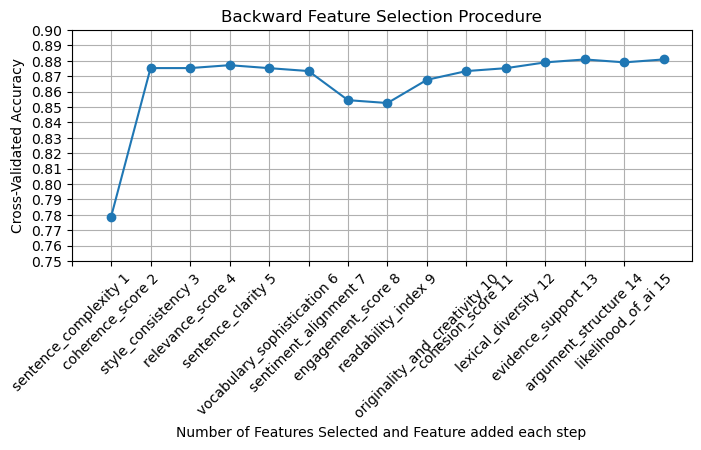

In [ ]:
# Plotting the backward selection procedure
plt.figure(figsize=(8, 3))
plt.plot(range(X_train.shape[1], 0, -1), accuracy_scores, marker='o')
plt.xlabel("Number of Features Selected and Feature added each step\nFor seperating pure AI Writing and AI assisted Human Writing")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Backward Feature Selection Procedure")
plt.grid(True)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

# Annotate each point with the corresponding backward features
#for i, txt in enumerate(reversed(backward_features)):
#    plt.annotate(txt, (X_train.shape[1] - i, accuracy_scores[i]), fontsize=10, ha='center', va='bottom')
plt.xticks(range(X_train.shape[1]), [f"{feature} {i+1}" for i, feature in enumerate(backward_features)], rotation=45)
plt.yticks(np.arange(0.75, 0.90, 0.01))
plt.show()

# add in embedding for the re-write ones

In [90]:
import json
import numpy as np
from tqdm import tqdm
import utils.tokenize
importlib.reload(utils.tokenize)
from utils.tokenize import embed_batch, embed_text
batch_size = 1
def process_texts(texts, filename):
    def safe_embed_string(text_batch):
        try:
            return embed_batch(text_batch)
        except Exception as e:
            return [None] * len(text_batch)

    #results = []
    for i in tqdm(range(0, len(texts), batch_size), total=len(texts)//batch_size):
        batch = texts[i:i+batch_size]
        batch_results = safe_embed_string(batch)
        #results.extend(batch_results)
        for batch_result in batch_results:
            if batch_result is not None and isinstance(batch_result['embedding'], np.ndarray):
                batch_result['embedding'] = batch_result['embedding'].tolist()
        with open(filename, 'a') as f:
            json.dump(batch_results, f)
            f.write('\n')
    
    #return results

In [91]:
process_texts(rewritedf['text'], 'embedding_rewrite_aifix.json')

100%|██████████| 331/331 [00:24<00:00, 13.24it/s]


In [92]:
# Initialize an empty list to store the JSON objects
json_objects = []

# Open the JSON file and read each line
with open('embedding_rewrite_aifix.json', 'r') as file:
    for line in file:
        # Each line contains multiple JSON objects
        objects = json.loads(line)
        json_objects.extend(objects)

# Convert the list of JSON objects into a DataFrame
embedding_df = pd.DataFrame(json_objects)

# Display the DataFrame
print(embedding_df.head())

                                           embedding  \
0  [0.013550756499171257, -0.04553204029798508, 0...   
1  [0.017322717234492302, -0.06695210933685303, 0...   
2  [-0.004775296431034803, -0.047154590487480164,...   
3  [-0.024001305922865868, -0.05157630145549774, ...   
4  [-0.008195663802325726, -0.06397079676389694, ...   

                                       text_embedded  text_embedding_tc  
0  what is the electoral college? the electoral c...                510  
1  dear senator, i feel the need to eliminate the...                510  
2  in the intense debate concerning the validity ...                510  
3  dear florida senator, i believe that we should...                312  
4  dear mr. senator, february 3, 2015electoral co...                355  


In [93]:
rewritedf = pd.concat([rewritedf, embedding_df], axis=1)

In [96]:
rewritedf.to_pickle('./data/rewritedf.pkl')

evaldf = 